<a href="https://colab.research.google.com/github/Yash1289/rossmann_sales_prediction/blob/main/Rossmann_Sales_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Sales Prediction : Predicting sales of a major store chain Rossmann</u></b>

## <b> Problem Description </b>

### Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.

### You are provided with historical sales data for 1,115 Rossmann stores. The task is to forecast the "Sales" column for the test set. Note that some stores in the dataset were temporarily closed for refurbishment.

## <b> Data Description </b>

### <b>Rossmann Stores Data.csv </b> - historical data including Sales
### <b>store.csv </b> - supplemental information about the stores


### <b><u>Data fields</u></b>
### Most of the fields are self-explanatory. The following are descriptions for those that aren't.

* #### Id - an Id that represents a (Store, Date) duple within the test set
* #### Store - a unique Id for each store
* #### Sales - the turnover for any given day (this is what you are predicting)
* #### Customers - the number of customers on a given day
* #### Open - an indicator for whether the store was open: 0 = closed, 1 = open
* #### StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
* #### SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools
* #### StoreType - differentiates between 4 different store models: a, b, c, d
* #### Assortment - describes an assortment level: a = basic, b = extra, c = extended
* #### CompetitionDistance - distance in meters to the nearest competitor store
* #### CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened
* #### Promo - indicates whether a store is running a promo on that day
* #### Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
* #### Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2
* #### PromoInterval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [4]:
path1 = "/content/drive/MyDrive/Rossmann Stores Data.csv"
rossmann_df = pd.read_csv(path1 , low_memory = False)

In [5]:
rossmann_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [6]:
rossmann_df.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday'],
      dtype='object')

In [7]:
rossmann_df.shape

(1017209, 9)

In [8]:
path2 = "/content/drive/MyDrive/store.csv"
store_df = pd.read_csv(path2)

In [9]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [10]:
store_df.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [11]:
store_df.shape

(1115, 10)

In [12]:
rossmann_df["Store"].value_counts()


1023    942
666     942
675     942
163     942
674     942
       ... 
900     758
902     758
903     758
904     758
512     758
Name: Store, Length: 1115, dtype: int64

In [13]:
rossmann_df["DayOfWeek"].unique()

array([5, 4, 3, 2, 1, 7, 6])

In [14]:
rossmann_df[rossmann_df.duplicated( subset = ["Store" , "Date"])]

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday


In [15]:
pd.DataFrame(rossmann_df.dtypes).rename(columns = {0:'dtype'})

,dtype
Store,int64
DayOfWeek,int64
Date,object
Sales,int64
Customers,int64
Open,int64
Promo,int64
StateHoliday,object
SchoolHoliday,int64


In [16]:
rossmann_df.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

In [17]:
rossmann_df = pd.merge(rossmann_df , store_df , how = "left" , on="Store")
rossmann_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [18]:
rossmann_df["Date"] = pd.to_datetime(rossmann_df["Date"])

In [19]:
max_date = rossmann_df["Date"].max()
min_date = rossmann_df["Date"].min()

print(f"{min_date}")
print(f"{max_date}")

2013-01-01 00:00:00
2015-07-31 00:00:00


In [20]:
rossmann_sales_df = rossmann_df.copy()

In [21]:
rossmann_sales_df = rossmann_sales_df.sort_values(by = "Date", ignore_index = True)

In [22]:
rossmann_sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1115,2,2013-01-01,0,0,0,0,a,1,d,c,5350.0,NaN,NaN,1,22.0,2012.0,"Mar,Jun,Sept,Dec"
1,379,2,2013-01-01,0,0,0,0,a,1,d,a,6630.0,NaN,NaN,0,NaN,NaN,NaN
2,378,2,2013-01-01,0,0,0,0,a,1,a,c,2140.0,8.0,2012.0,0,NaN,NaN,NaN
3,377,2,2013-01-01,0,0,0,0,a,1,a,c,100.0,6.0,2010.0,1,18.0,2010.0,"Feb,May,Aug,Nov"
4,376,2,2013-01-01,0,0,0,0,a,1,a,a,160.0,8.0,2012.0,0,NaN,NaN,NaN


In [23]:
closedStore_index = rossmann_sales_df[rossmann_sales_df["Open"] == 0].index
rossmann_sales_df.drop(closedStore_index , inplace = True )

zeroSale_index = rossmann_sales_df[rossmann_sales_df["Sales"] == 0].index
rossmann_sales_df.drop(zeroSale_index, inplace = True)

In [24]:
rossmann_sales_df.reset_index(drop = True , inplace = True)

In [25]:
rossmann_sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,353,2,2013-01-01,3139,820,1,0,a,1,b,b,900.0,NaN,NaN,1,14.0,2013.0,"Feb,May,Aug,Nov"
1,335,2,2013-01-01,2401,482,1,0,a,1,b,a,90.0,NaN,NaN,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
2,512,2,2013-01-01,2646,625,1,0,a,1,b,b,590.0,NaN,NaN,1,5.0,2013.0,"Mar,Jun,Sept,Dec"
3,494,2,2013-01-01,3113,527,1,0,a,1,b,a,1260.0,6.0,2011.0,0,NaN,NaN,NaN
4,530,2,2013-01-01,2907,532,1,0,a,1,a,c,18160.0,NaN,NaN,0,NaN,NaN,NaN


In [26]:
rossmann_sales_df.shape

(844338, 18)

In [27]:
rossmann_sales_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance            2186
CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64

In [28]:

rossmann_sales_df["CompetitionOpenSinceMonth"] = np.where(rossmann_sales_df["CompetitionDistance"].isna() , 0 , rossmann_sales_df["CompetitionOpenSinceMonth"])
rossmann_sales_df["CompetitionOpenSinceYear"] = np.where(rossmann_sales_df["CompetitionDistance"].isna() , 0 , rossmann_sales_df["CompetitionOpenSinceYear"])
rossmann_sales_df["CompetitionDistance"] = rossmann_sales_df["CompetitionDistance"].fillna(0)


In [29]:
rossmann_sales_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth    266414
CompetitionOpenSinceYear     266414
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64

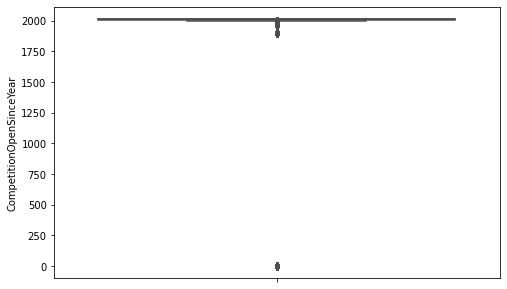

In [30]:
import seaborn as sns
plt.figure(figsize = (8,5))
sns.boxplot( y = "CompetitionOpenSinceYear" , data = rossmann_sales_df, palette = "bright")

In [31]:

rossmann_sales_df["CompetitionOpenSinceYear"] = np.where(rossmann_sales_df["CompetitionOpenSinceYear"].isna() , rossmann_sales_df["CompetitionOpenSinceYear"].mode() , rossmann_sales_df["CompetitionOpenSinceYear"])
rossmann_sales_df["CompetitionOpenSinceMonth"] = np.where(rossmann_sales_df["CompetitionOpenSinceMonth"].isna() , rossmann_sales_df["CompetitionOpenSinceMonth"].mode() , rossmann_sales_df["CompetitionOpenSinceMonth"])


In [32]:
rossmann_sales_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
CompetitionOpenSinceMonth         0
CompetitionOpenSinceYear          0
Promo2                            0
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64

In [33]:
for index, row in rossmann_sales_df.iterrows():
  if row["Date"].year < row["CompetitionOpenSinceYear"] or(row["Date"].year == row["CompetitionOpenSinceYear"] and row["Date"].month < row["CompetitionOpenSinceMonth"]) :
    rossmann_sales_df.at[index, "CompetitionOpenSinceYear"] = 0 
    rossmann_sales_df.at[index, "CompetitionOpenSinceMonth"] = 0
    rossmann_sales_df.at[index, "CompetitionDistance"] = 0

In [34]:
def MonthsOfCompetition(row):
  if row["CompetitionOpenSinceYear"] != 0:
    return ((row["Date"].year - row["CompetitionOpenSinceYear"])*12 + (row["Date"].month - row["CompetitionOpenSinceMonth"]))
  else:
    return 0

In [35]:
rossmann_sales_df["NumberOfMonthsFacedCompetition"] = rossmann_sales_df.apply(MonthsOfCompetition , axis = 1)

In [36]:
rossmann_sales_df.drop(["CompetitionOpenSinceMonth" , "CompetitionOpenSinceYear"] , axis = 1 , inplace = True )

In [37]:
rossmann_sales_df["PromoInterval"] = rossmann_sales_df["PromoInterval"].fillna(0)

In [38]:
def PromoMonth(row):
  if isinstance(row["PromoInterval"], str):
    if row["Date"].strftime("%b") in row["PromoInterval"].split(","):
      return 1
    else:
      return 0
  else:
    return -1


In [39]:
rossmann_sales_df["isPromoMonth"] = rossmann_sales_df.apply(PromoMonth ,axis = 1)

In [40]:
rossmann_sales_df.drop(["PromoInterval"] , axis=1 , inplace = True)

In [41]:
def Promo2Running(row):
  if row["Promo2"] != 0 :
    if ( row["Date"].year < row["Promo2SinceYear"] ) or ( row["Date"].year == row["Promo2SinceYear"] and row["Date"].month < (row["Promo2SinceWeek"]//4 +1)):
      return 0
    else:
      return 1
  else:
    return 0

In [42]:
rossmann_sales_df["Promo2"] = rossmann_sales_df.apply(Promo2Running , axis = 1)

In [43]:
rossmann_sales_df["isPromoMonth"].value_counts()

-1    423292
 0    280897
 1    140149
Name: isPromoMonth, dtype: int64

In [44]:
rossmann_sales_df["isPromoMonth"] = np.where(rossmann_sales_df["Promo2"] == 0 , -1 , rossmann_sales_df["isPromoMonth"])

In [45]:
rossmann_sales_df["isPromoMonth"].value_counts()

-1    481165
 0    241357
 1    121816
Name: isPromoMonth, dtype: int64

In [46]:
rossmann_sales_df["Promo2SinceWeek"] = rossmann_sales_df["Promo2SinceWeek"].fillna(0)
rossmann_sales_df["Promo2SinceYear"] = rossmann_sales_df["Promo2SinceYear"].fillna(0)

In [47]:
rossmann_sales_df.isnull().sum()

Store                             0
DayOfWeek                         0
Date                              0
Sales                             0
Customers                         0
Open                              0
Promo                             0
StateHoliday                      0
SchoolHoliday                     0
StoreType                         0
Assortment                        0
CompetitionDistance               0
Promo2                            0
Promo2SinceWeek                   0
Promo2SinceYear                   0
NumberOfMonthsFacedCompetition    0
isPromoMonth                      0
dtype: int64

In [48]:
def MonthsPromo2(row):
  if row["Promo2"] != 0:
    return (( row["Date"].year - row["Promo2SinceYear"])*12 + (row["Date"].month - (row["Promo2SinceWeek"]//4 +1)))
  else:
    return 0

In [49]:
rossmann_sales_df["MonthsOfPromo2"] = rossmann_sales_df.apply(MonthsPromo2 , axis = 1)

In [50]:
rossmann_sales_df.drop(["Promo2SinceYear" , "Promo2SinceWeek"] , axis = 1 , inplace = True )

In [51]:
rossmann_sales_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2,NumberOfMonthsFacedCompetition,isPromoMonth,MonthsOfPromo2
0,353,2,2013-01-01,3139,820,1,0,a,1,b,b,0.0,0,0.0,-1,0.0
1,335,2,2013-01-01,2401,482,1,0,a,1,b,a,0.0,0,0.0,-1,0.0
2,512,2,2013-01-01,2646,625,1,0,a,1,b,b,0.0,0,0.0,-1,0.0
3,494,2,2013-01-01,3113,527,1,0,a,1,b,a,1260.0,0,19.0,-1,0.0
4,530,2,2013-01-01,2907,532,1,0,a,1,a,c,0.0,0,0.0,-1,0.0


In [138]:
rossmann_sales_df["Month"] = rossmann_sales_df["Date"].apply(lambda x : x.month)
rossmann_sales_df["Year"] = rossmann_sales_df["Date"].apply(lambda x : x.year)

In [139]:
rossmann_model_df = rossmann_sales_df.copy()

In [54]:
rossmannSales_groupby = rossmann_model_df.groupby(["Store" , "Month" , "Year"]).agg({ "Sales" : "mean" , "Customers" : "mean" }).reset_index()

In [55]:
grouped_df = rossmannSales_groupby.sort_values(by = [ "Store" , "Year" , "Month" ] ,ignore_index="True")
grouped_df.head()

,Store,Month,Year,Sales,Customers
0,1,1,2013,4939.653846,611.500000
1,1,2,2013,5219.625000,632.875000
2,1,3,2013,5806.760000,702.960000
3,1,4,2013,4720.360000,575.280000
4,1,5,2013,5140.217391,607.173913


In [56]:
grouped_df.shape

(33465, 5)

In [57]:
listOfStores = grouped_df["Store"].unique()

In [58]:
shifted_df = grouped_df.copy()

for storeNo in listOfStores :
  shifted_df.loc[shifted_df["Store"] == storeNo , "Sales" ] = shifted_df[shifted_df["Store"] == storeNo ]["Sales"].shift( periods=2, fill_value=0 )
  shifted_df.loc[shifted_df["Store"] == storeNo , "Customers" ] = shifted_df[shifted_df["Store"] == storeNo ]["Customers"].shift( periods = 2 , fill_value = 0)


In [59]:
shifted_df.rename(columns = {"Sales" : "2MonthAgoSale" , "Customers" : "2MonthAgoCustomers" } ,inplace = True)

In [60]:
shifted_df.head()

,Store,Month,Year,2MonthAgoSale,2MonthAgoCustomers
0,1,1,2013,0.000000,0.000
1,1,2,2013,0.000000,0.000
2,1,3,2013,4939.653846,611.500
3,1,4,2013,5219.625000,632.875
4,1,5,2013,5806.760000,702.960


In [61]:
rossmann_model_df = pd.merge(rossmann_model_df , shifted_df , how = "left" , on = ["Store" , "Month" , "Year"])

In [62]:
index_places1 = rossmann_model_df[rossmann_model_df["2MonthAgoSale"] == 0].index
rossmann_model_df.drop( index_places1 , inplace = True )

In [63]:
rossmann_temp_df = rossmann_model_df.copy()

In [64]:
rossmann_temp_df = pd.get_dummies( rossmann_temp_df , columns = ["StoreType" , "Assortment" ] , prefix = [ "StoreType" , "Assortment_type" ])

In [65]:
encoder_nums = { "StateHoliday" : { "0" : 0 , "a" : 1 , "b" : 3 , "c" : 2} } 

rossmann_temp_df = rossmann_temp_df.replace(encoder_nums)

In [66]:
rossmann_temp_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,CompetitionDistance,Promo2,NumberOfMonthsFacedCompetition,isPromoMonth,MonthsOfPromo2,Month,Year,2MonthAgoSale,2MonthAgoCustomers,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_type_a,Assortment_type_b,Assortment_type_c
55547,373,5,2013-03-01,4074,308,1,0,0,0,0.0,1,0.0,0,9.0,3,2013,3795.307692,277.923077,0,0,0,1,0,0,1
55548,369,5,2013-03-01,6643,542,1,0,0,0,0.0,0,0.0,-1,0.0,3,2013,6424.153846,528.769231,0,0,0,1,0,0,1
55549,370,5,2013-03-01,7152,645,1,0,0,0,8250.0,1,149.0,0,43.0,3,2013,6823.461538,571.192308,0,0,0,1,1,0,0
55550,371,5,2013-03-01,5774,473,1,0,0,0,1970.0,0,44.0,-1,0.0,3,2013,6373.846154,514.269231,0,0,0,1,0,0,1
55551,372,5,2013-03-01,8214,759,1,0,0,0,4880.0,0,31.0,-1,0.0,3,2013,7761.884615,702.000000,0,0,0,1,0,0,1


In [90]:
rossmann_temp_df.shape

(788643, 25)

## Eda Section

In [140]:
rossmann_eda_df = rossmann_sales_df.copy()

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

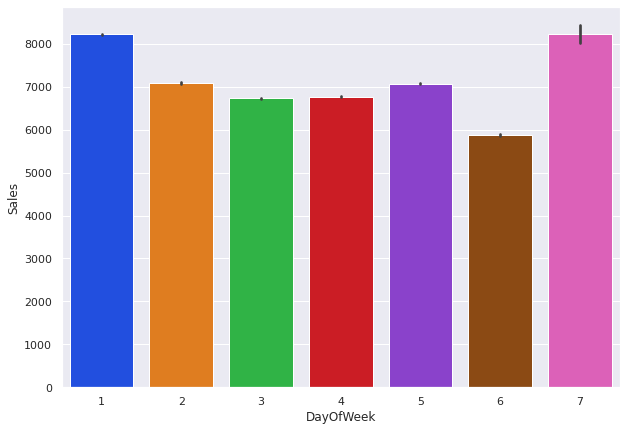

In [118]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='DayOfWeek',y='Sales',data = rossmann_eda_df , palette = 'bright',estimator = np.mean)


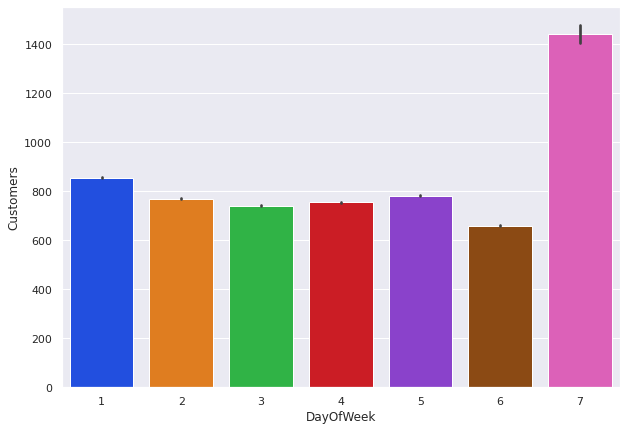

In [119]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='DayOfWeek',y= 'Customers' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

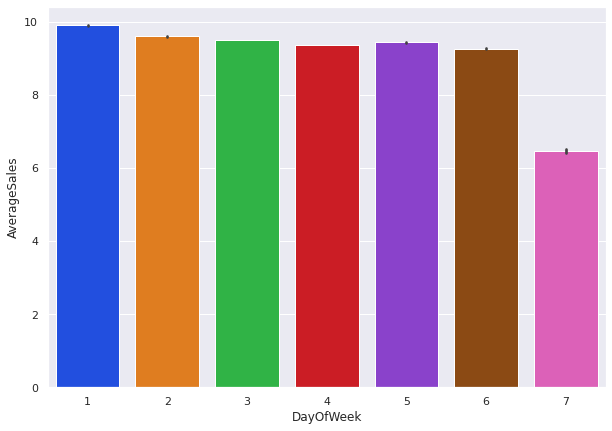

In [120]:
rossmann_eda_df["AverageSales"] = rossmann_eda_df["Sales"]/rossmann_eda_df["Customers"]

plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='DayOfWeek', y='AverageSales' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

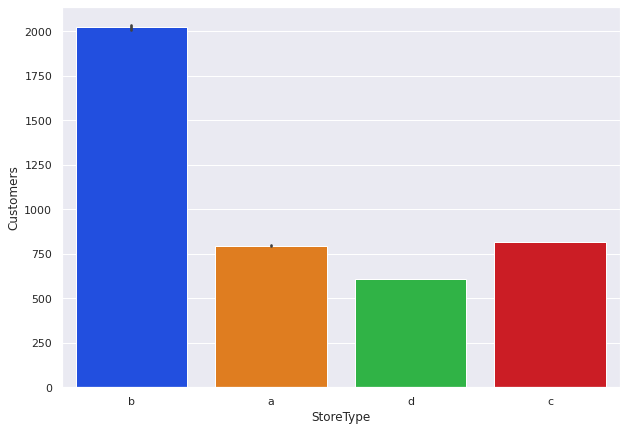

In [121]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='StoreType',y= 'Customers' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

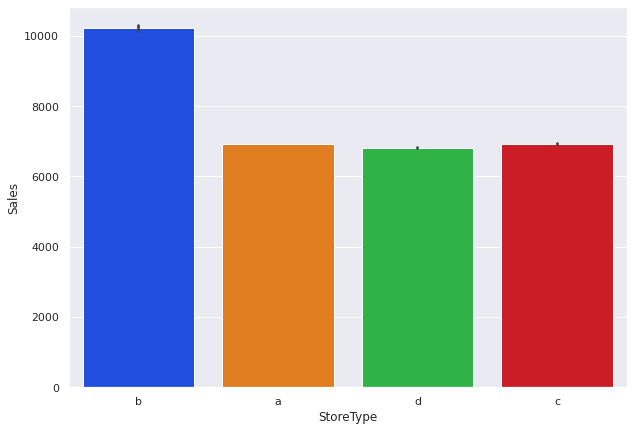

In [127]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='StoreType',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

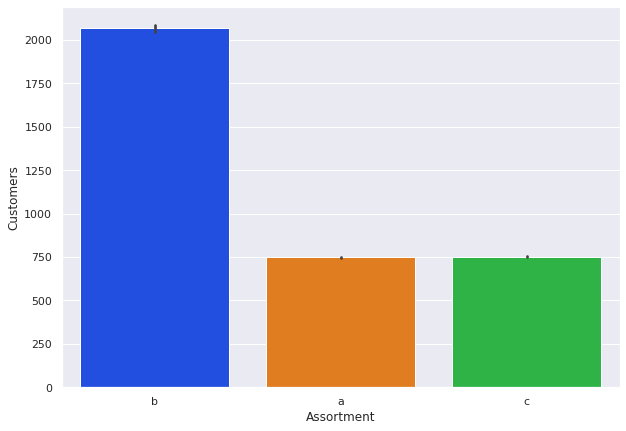

In [128]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='Assortment',y= 'Customers' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

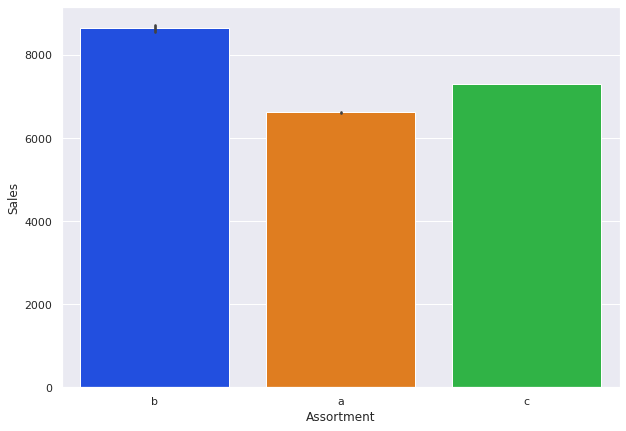

In [129]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='Assortment',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

In [130]:
rossmann_eda_groupby = rossmann_eda_df.groupby(["StoreType" , "Assortment"] , sort=False).agg({ "Date" : "count"}).reset_index()

rossmann_eda_pivot = rossmann_eda_groupby.pivot(index = "StoreType" , columns="Assortment" , values = "Date")
rossmann_eda_pivot

Assortment,a,b,c
StoreType,,,
a,286028.0,NaN,171014.0
b,6409.0,8209.0,942.0
c,58554.0,NaN,54414.0
d,93884.0,NaN,164884.0


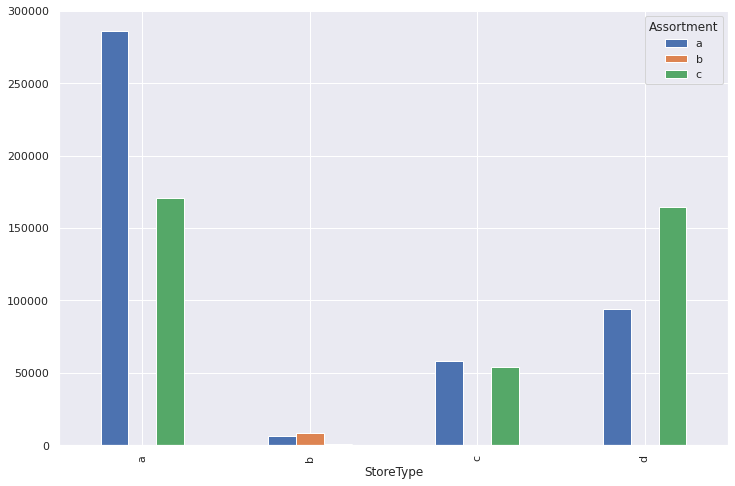

In [131]:
plt.rcParams['figure.figsize'] = 8,5

rossmann_eda_pivot.fillna(0 , axis = 1 , inplace = True)
rossmann_eda_pivot.plot(kind="bar" , figsize=(12,8))

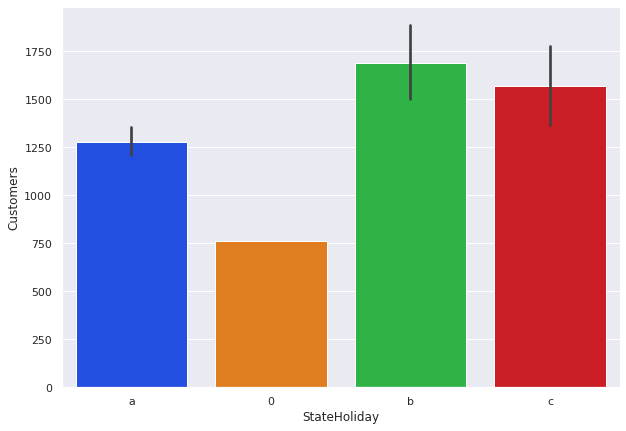

In [132]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='StateHoliday',y= 'Customers' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

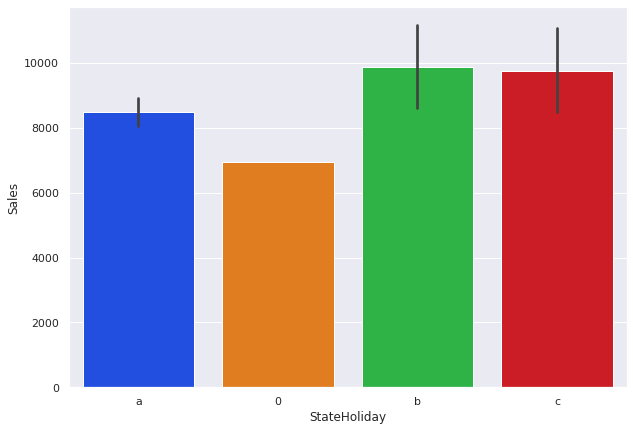

In [133]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='StateHoliday',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

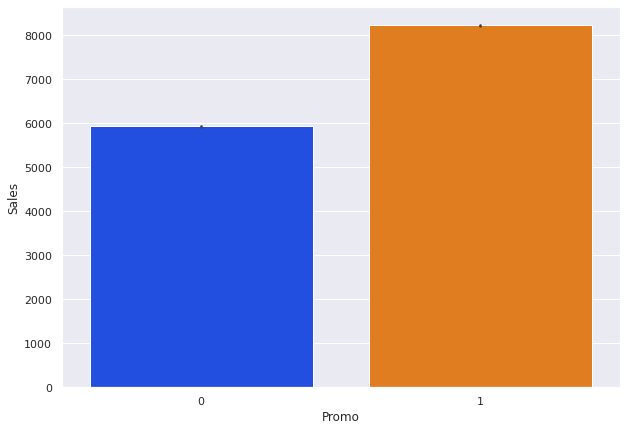

In [134]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
g = sns.barplot(x='Promo',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

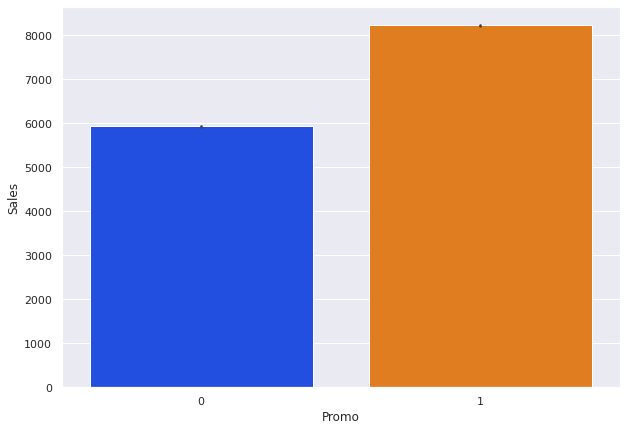

In [137]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
sns.barplot(x='Promo',y= 'Customers' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)
sns.barplot(x='Promo',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

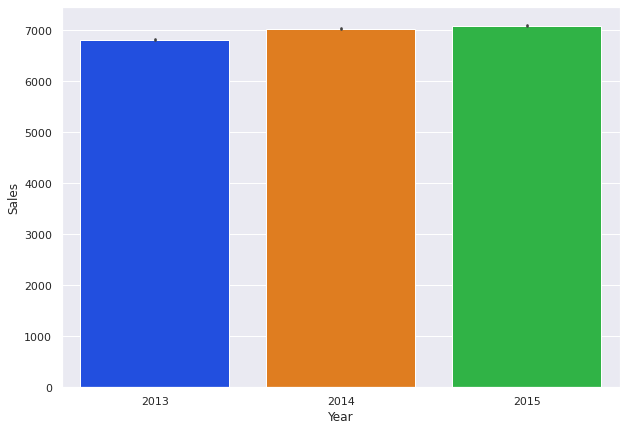

In [141]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
sns.barplot(x='Year',y= 'Sales' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

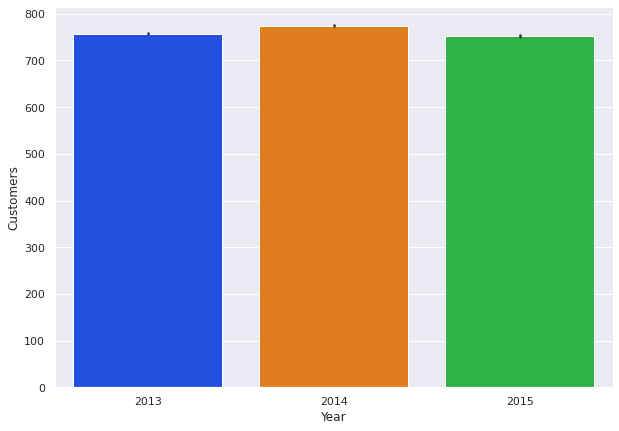

In [142]:
plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
sns.barplot(x='Year',y= 'Customers' ,data = rossmann_eda_df , palette = 'bright',estimator = np.mean)

In [158]:
 = rossmann_eda_df.groupby("Month").agg({ "Sales" : "mean"}).reset_index().sort_values(by = "Sales" , ignore_index = True)
rossmann_months_groupby.tail()

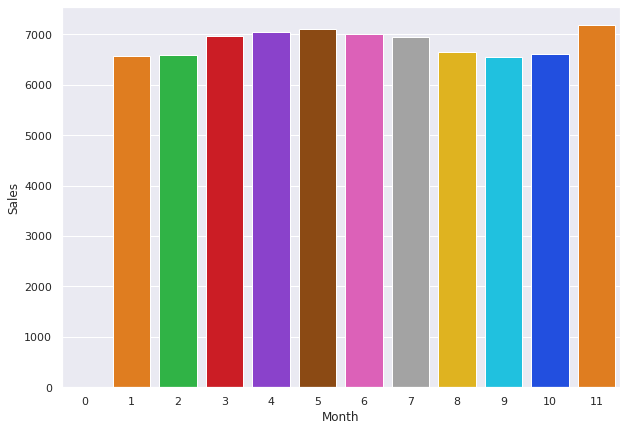

In [159]:

plt.rcParams['figure.figsize'] = 10,7
sns.set_context('paper', font_scale=1.4)
sns.set_theme(style='darkgrid')
sns.barplot(x='Month',y= 'Sales' ,data = rossmann_months_groupby , palette = 'bright' ,estimator = np.mean )

## Model Implementation Section

In [ ]:
numerical_features = [ "CompetitionDistance" , "NumberOfMonthsFacedCompetition" , "MonthsOfPromo2" ,"Customers" , "Sales" ,"2MonthAgoSale" ,"2MonthAgoCustomers"]

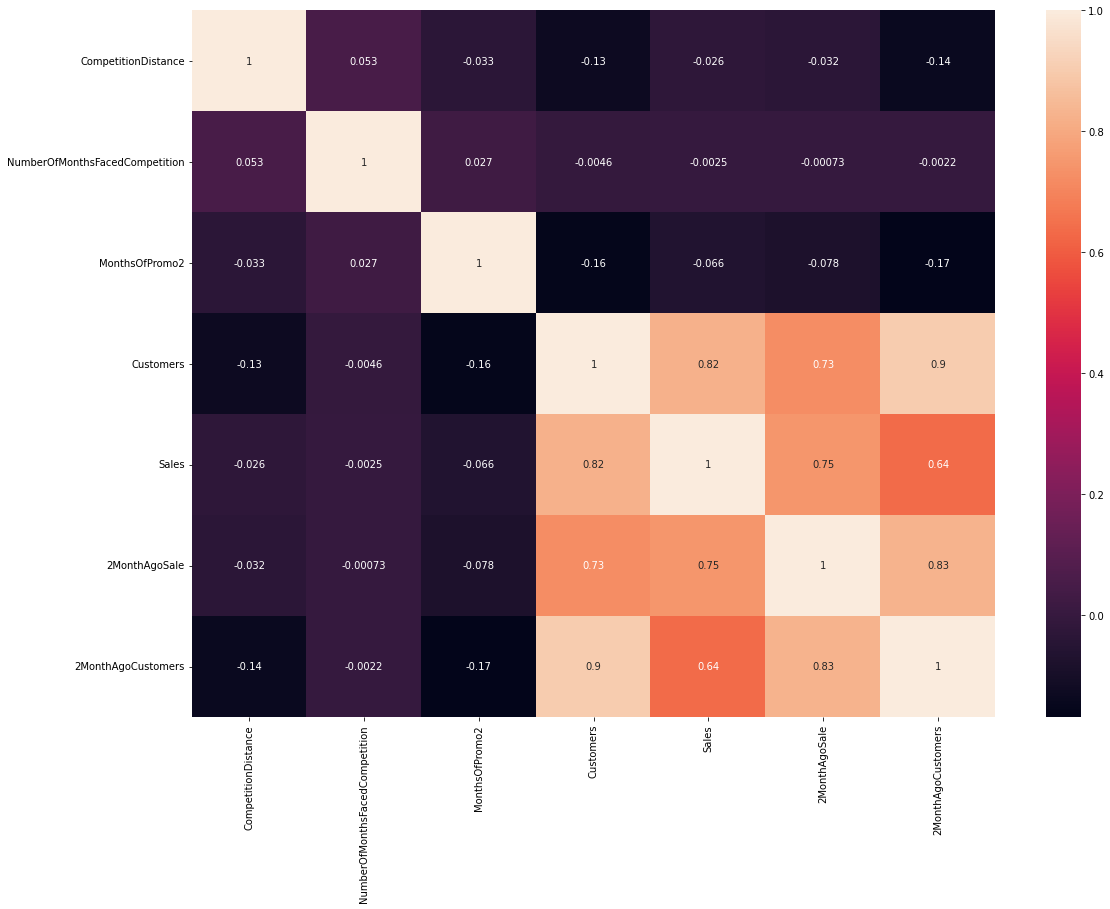

In [ ]:
plt.figure(figsize=(18, 13))
corr = rossmann_temp_df[numerical_features].corr()
sns.heatmap(corr , annot = True )

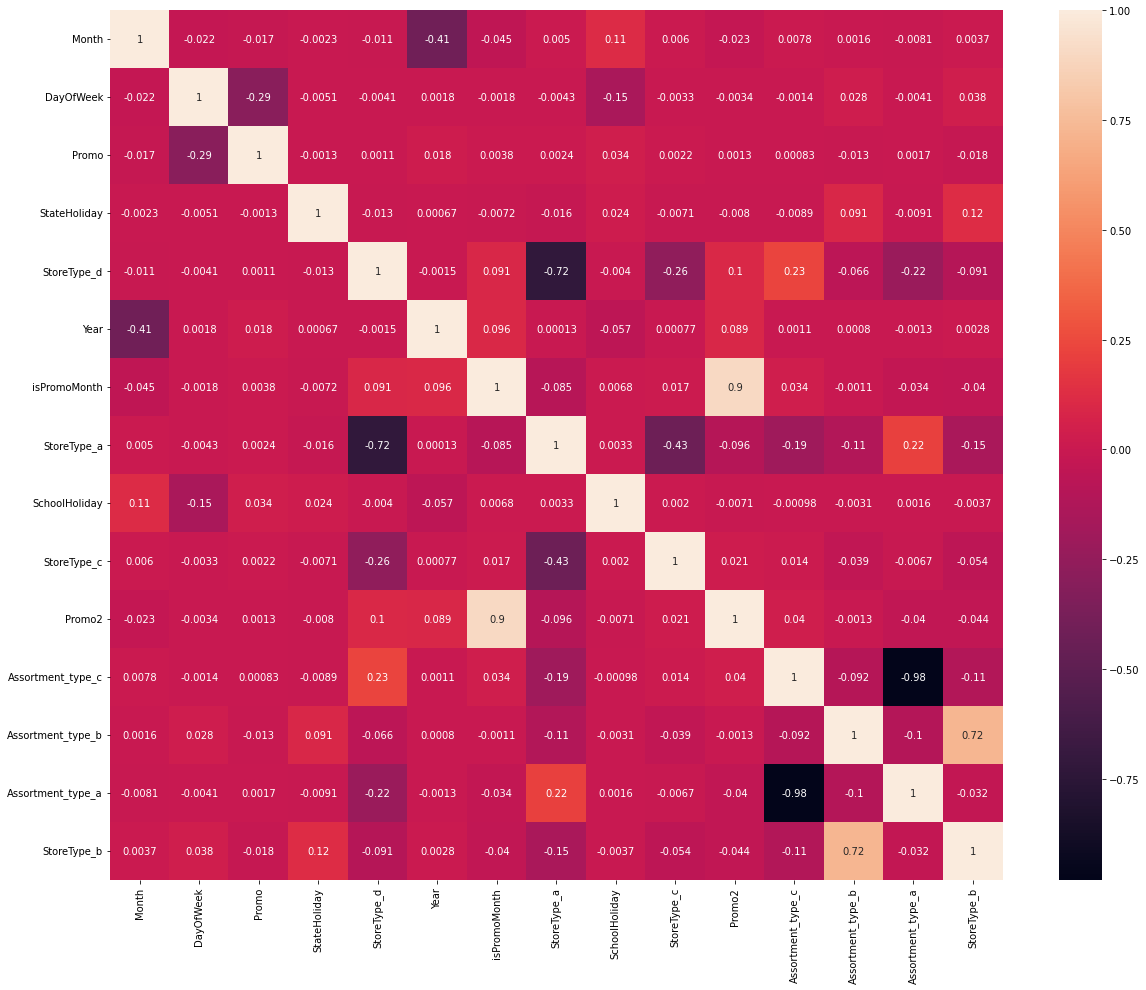

In [ ]:
plt.figure(figsize = (20,16))
otherFeatures = list(set(rossmann_temp_df.describe().columns) - set(numerical_features) - {"Store" , "Open"})
corr2 = rossmann_temp_df[otherFeatures].corr()
sns.heatmap(corr2 , annot = True)

In [ ]:
rossmann_temp_df.drop(["Open"] , axis = 1 , inplace = True)

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
correlation_features = ["CompetitionDistance" , "NumberOfMonthsFacedCompetition" , "MonthsOfPromo2" , "2MonthAgoSale" ]

In [ ]:
calc_vif(rossmann_temp_df[correlation_features])

,variables,VIF
0,CompetitionDistance,1.324816
1,NumberOfMonthsFacedCompetition,1.447870
2,MonthsOfPromo2,1.371282
3,2MonthAgoSale,1.936576


In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [ ]:
rossmann_temp_df.describe().columns

Index(['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'CompetitionDistance', 'Promo2',
       'NumberOfMonthsFacedCompetition', 'isPromoMonth', 'MonthsOfPromo2',
       'Month', 'Year', '2MonthAgoSale', '2MonthAgoCustomers', 'StoreType_a',
       'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_type_a',
       'Assortment_type_b', 'Assortment_type_c'],
      dtype='object')

In [ ]:
independent_features = rossmann_temp_df.describe().columns
independent_features = list(set(independent_features) - { "Sales" , "Customers" , "StoreType_a" , "2MonthAgoCustomers" ,"Promo2" , "Assortment_type_a" })

In [ ]:
break_point = round(len(rossmann_temp_df)*0.90)
train_data = rossmann_temp_df.iloc[:break_point]
test_data = rossmann_temp_df.iloc[break_point:]
X_train = train_data[independent_features].copy()
Y_train = train_data["Sales"].copy()
X_test = test_data[independent_features].copy()
Y_test = test_data["Sales"].copy()

In [ ]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)

X_test = scaler.transform(X_test)

In [ ]:
from sklearn.linear_model import Ridge
ridge  = Ridge(alpha= 100 , max_iter= 3000)

ridge.fit(X_train, Y_train)

Ridge(alpha=100, max_iter=3000)

In [ ]:
ridge.score(X_train , Y_train)

0.701107781405989

In [ ]:
Y_pred_ridge = ridge.predict(X_test)

In [ ]:
MSE  = mean_squared_error((Y_test), (Y_pred_ridge))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((Y_test), (Y_pred_ridge))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score((Y_test), (Y_pred_ridge)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

In [ ]:
from sklearn.linear_model import Ridge
ridge = Ridge()
tscv = TimeSeriesSplit(n_splits = 2,test_size=59104)

parameters = {'alpha': [1e-6 , 1e-7 , 1e-5,1e-4,1e-3,1e-2,1e-1,1,5,10,20,30,40,50,60,100,1000]}
lasso_regressor = GridSearchCV(ridge , param_grid = parameters, scoring= 'r2' , cv=tscv)
lasso_regressor.fit(X_train, Y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=59104),
             estimator=Ridge(),
             param_grid={'alpha': [1e-06, 1e-07, 1e-05, 0.0001, 0.001, 0.01,
                                   0.1, 1, 5, 10, 20, 30, 40, 50, 60, 100,
                                   0.0014]},
             scoring='r2')

In [ ]:
MSE  = mean_squared_error((Y_test), (Y_pred_ridge))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((Y_test), (Y_pred_ridge))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score((Y_test), (Y_pred_ridge)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

In [ ]:
break_point = round(len(rossmann_temp_df)*0.90)
train_data = rossmann_temp_df.iloc[:break_point]
test_data = rossmann_temp_df.iloc[break_point:]
X_train = train_data[independent_features].copy()
Y_train = train_data["Sales"].copy()
X_test = test_data[independent_features].copy()
Y_test = test_data["Sales"].copy()

In [ ]:
from sklearn.tree import DecisionTreeRegressor

decision_reg = DecisionTreeRegressor(criterion = "squared_error" , max_depth = 13 , max_features = "auto" )
decision_reg.fit(X_train , Y_train)

DecisionTreeRegressor(max_depth=13, max_features='auto')

In [ ]:
decision_reg.score(X_train  , Y_train)

0.857392682300747

In [ ]:
Y_pred_dec = decision_reg.predict(X_test)

In [ ]:
MSE  = mean_squared_error((Y_test), (Y_pred_dec))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((Y_test), (Y_pred_dec))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score((Y_test), (Y_pred_dec)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 1473360.2756713983
RMSE : 1213.8205286084917
R2 : 0.8415719297612188
Adjusted R2 :  0.8415357612627179


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_reg = GradientBoostingRegressor()
gradient_reg.fit(X_train , Y_train)

GradientBoostingRegressor()

In [ ]:
Y_pred_grad =gradient_reg.predict(X_test)

In [ ]:
gradient_reg.score(X_train , Y_train)

0.815378059121681

In [ ]:
MSE  = mean_squared_error((Y_test), (Y_pred_grad))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((Y_test), (Y_pred_grad))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score((Y_test), (Y_pred_grad)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 1458646.0351436655
RMSE : 1207.7441927592388
R2 : 0.8431541284741408
Adjusted R2 :  0.8431203109080507


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit

model = GradientBoostingRegressor()
tscv = TimeSeriesSplit(n_splits = 2,test_size=59104)

grid_values = {
    "learning_rate" : [ 0.1 ],
    "n_estimators" : [ 110 ],
    "max_depth" : [3]
}

gSearch = GridSearchCV( estimator = model , param_grid = grid_values , scoring = 'r2' , cv = tscv)
gSearch.fit(X_train , Y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=2, test_size=59104),
             estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1], 'max_depth': [3],
                         'n_estimators': [110]},
             scoring='r2')

In [ ]:
gSearch.best_score_

0.8021824502204853

In [ ]:
Y_pred_grad = gSearch.predict(X_test)

In [ ]:
MSE  = mean_squared_error((Y_test), (Y_pred_grad))
print("MSE :" , MSE)

RMSE = np.sqrt(MSE)
print("RMSE :" ,RMSE)

r2 = r2_score((Y_test), (Y_pred_grad))
print("R2 :" ,r2)
print("Adjusted R2 : ",1-(1-r2_score((Y_test), (Y_pred_grad)))*((X_test.shape[0]-1)/(X_test.shape[0]-X_test.shape[1]-1)))

MSE : 1338326.1249673232
RMSE : 1156.8604604563695
R2 : 0.8441979683578693
Adjusted R2 :  0.8441166039295495
